In [3]:
!pip install batoid

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 14.0 MB/s eta 0:00:0000:0100:01


In [1]:
import ipyvolume as ipv
import batoid
import numpy as np

In [2]:
az = -120  # degrees
alt = 42  # degrees
rotTelPos = 0  # degrees

# By default, batoid will load the LSST optics in the Optical Coordinate System described here:
# https://sitcomtn-003.lsst.io/#the-optical-coordinate-system.  I.e., the origin is at the 
# theoretical vertex of M1, +z points towards the sky, +x is parallel to the elevation bearing.

# For LSST + CBP, it's more convenient to make the global coordinate system fixed to the ground,
# something like the Terrestrial Coordinate System described in 
# https://docushare.lsst.org/docushare/dsweb/Get/Document-18499.

# We shift around the telescope to realize this change.  We also "point" the telescope according 
# to the above azimuth and altitude.

elevBearingHeight = 5.425  # Height of elevation bearing above azimuth ring

lsst = batoid.Optic.fromYaml("LSST_r.yaml")
lsst = lsst.withGlobalShift([0, 0, 3.53])  # Height of M1 vertex above azimuth ring
lsst = lsst.withLocallyRotatedOptic("LSSTCamera", batoid.RotZ(np.deg2rad(rotTelPos)))  # Camera rotator
lsst = lsst.withLocalRotation(batoid.RotZ(np.deg2rad(90-az)))  # Point in Az
lsst = lsst.withLocalRotation(batoid.RotX(np.deg2rad(90-alt)), rotCenter=[0, 0, elevBearingHeight], coordSys=batoid.globalCoordSys)  # Point in Alt

In [3]:
# Load Collimated Beam Projector and place it in the right position in the dome.
# The rotations below orient the CBP with respect to its default description such that
# it's aiming roughly at the LSST M1 mirror.  These were found through trial-and-error.
# The GlobalShift though should be pretty accurate.
cbp = batoid.Optic.fromYaml("CBP.yaml")
cbp = cbp.withLocalRotation(batoid.RotX(np.deg2rad(180)))
cbp = cbp.withLocalRotation(batoid.RotZ(np.deg2rad(150)))
cbp = cbp.withGlobalShift([-np.sin(np.deg2rad(30))*12.4, np.cos(np.deg2rad(30))*12.4, 12.135])
# cbp = cbp.withGlobalRotation(batoid.RotZ(np.deg2rad(daz)))  # optional 10 cm dome error
cbp = cbp.withLocalRotation(batoid.RotX(np.deg2rad(48)))

In [4]:
# Launch some rays, starting at the positions of some holes in the CBP focal plane.

nx = 20  # number of rays in ray-fan

# CBP focal plane hole positions in meters.
holes = [
    (0.0, 0.0),
    (-1.e-2, 0.0),
    (1.e-2, 0.0),
    (0.0, -1.e-2),
    (0.0, 1.e-2)
]
rvs = []
for hole in holes:
    # Set ray positions
    x = np.full(2*nx, hole[0])
    y = np.full(2*nx, hole[1])
    z = np.zeros_like(x)
    # Set ray angles.  We just sample uniformly between -0.3, 0.3 radians
    thx = np.concatenate([np.linspace(-0.3, 0.3, nx), np.zeros(nx)])
    thy = np.concatenate([np.zeros(nx), np.linspace(-0.3, 0.3, nx)])
    # Turn angles into velocities
    vx, vy, vz = batoid.utils.fieldToDirCos(thx, thy)
    # wavelength
    w = np.full_like(x, 500e-9)
    rvs.append(
        batoid.RayVector(x, y, z, vx, vy, vz, wavelength=w, coordSys=cbp['Detector'].coordSys)
    )
rvs = batoid.concatenateRayVectors(rvs)

In [5]:
# Trace!
# Start by tracing CBP optics in reverse; from focal plane to the Schmidt plate "entrance".
tf_cbp = cbp.traceFull(rvs, reverse=True)
# Then take the results of that and push them through the LSST optics.
tf_lsst = lsst.traceFull(tf_cbp['Schmidt_plate_entrance']['out'])

In [6]:
# Visualize
fig = ipv.figure(height=600, width=800)
ipv.style.set_style_dark()
ipv.style.box_off()
# ipv.style.axes_off()
lsst.draw3d(ipv, color='cyan')
cbp.draw3d(ipv, color='red')
batoid.drawTrace3d(ipv, tf_cbp, color='yellow')
batoid.drawTrace3d(ipv, tf_lsst, color='yellow')

ipv.xlim(-10, 10)
ipv.ylim(-10, 10)
ipv.zlim(0, 20)
ipv.show()

In [7]:
import matplotlib.pyplot as plt

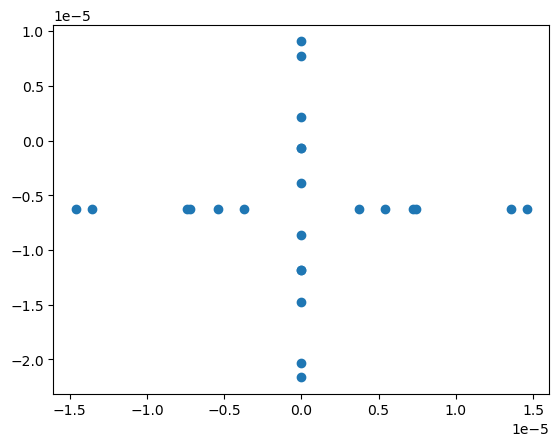

In [8]:
# Where did the rays impact the LSST Focal Plane?

# Just plot rays for one hole at a time
ihole = 0

optic = 'Detector'

w = ~tf_lsst[optic]['out'][ihole*40:(ihole+1)*40].vignetted
x = tf_lsst[optic]['out'][ihole*40:(ihole+1)*40].x
y = tf_lsst[optic]['out'][ihole*40:(ihole+1)*40].y

mx = np.mean(x)
my = np.mean(y)


plt.figure()
plt.scatter(x[w], y[w])
plt.show()

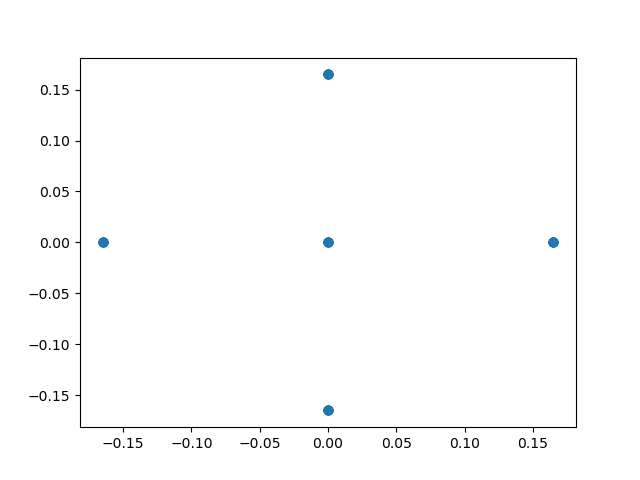

In [10]:
%matplotlib widget
# Show all spots.  Zoom in to see individual rays
optic = 'Detector'

w = ~tf_lsst[optic]['out'].vignetted
x = tf_lsst[optic]['out'].x
y = tf_lsst[optic]['out'].y

plt.figure()
plt.scatter(x[w], y[w])
plt.show()